In [1]:
!python -m pip install pyyaml==5.1

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'



  Cloning https://github.com/facebookresearch/detectron2.git to /tmp/pip-req-build-4fl9z_7d
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-4fl9z_7d

  Resolved https://github.com/facebookresearch/detectron2.git to commit 9604f5995cc628619f0e4fd913453b4d7d61db3f
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 105.2 MB/s eta 0:00:00
  Created wheel for detectron2: filename=detectron2-0.6-cp310-cp310-linux_x86_64.whl size=901726 sha256=1af63a4c211fbd5e335fda77a522b781c3da45f0f539de86bd15c361724c794e
  Stored in directory: /tmp/pip-ephem-wheel-cache-vzork1k1/wheels/47/e5/15/94c80df2ba85500c5d76599cc307c0a7079d0e221bb6fc4375
  Created wheel for fvcore: filename=fvcore-0.1.5.post20221221-py3-none-any.whl size=61443 sha256=d77dd18b5c9876d846211ed5a9d37a3670d2a18797bc8cbd4aa1f70429954dfc
  Stored in directory: /home/zeus/.cache/p

In [1]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0
torch:  2.2 ; cuda:  cu121
detectron2: 0.6


In [2]:
!pip install opencv-python


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 47.5 MB/s eta 0:00:00:00:0100:01


In [7]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [4]:
!curl -L "https://universe.roboflow.com/ds/OoffgDRtBF?key=nHXCifHwcG" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   901  100   901    0     0   2824      0 --:--:-- --:--:-- --:--:--  2824
100  109M  100  109M    0     0  62.1M      0  0:00:01  0:00:01 --:--:--  107M
Archive:  roboflow.zip
 extracting: README.dataset.txt      
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/10151676249171_-pic_hd_jpg.rf.ae486069f6569cdb2fccc94fd2c847c8.jpg  
 extracting: test/10171676249230_-pic_jpg.rf.284069b7dcc7a5264cc778e2fce409fa.jpg  
 extracting: test/10251676249355_-pic_hd_jpg.rf.9a0ac5a465725fb37ef60bf5677356ec.jpg  
 extracting: test/5_png_jpg.rf.c164254ab9d0f3d942d65cc49e488bea.jpg  
 extracting: test/6451674985940_-pic_jpg.rf.d8105ce7963e408760f27a2d62add578.jpg  
 extracting: test/6531674986027_-pic_jpg.rf.f3006cbaaf27d7880234842169e392c9.jpg  
 extracting: test/6581674986076_-pic_jpg.rf.b24b0cc9347e8ca4ee004997492b

In [9]:
import os
import copy
import torch
import cv2
import numpy as np
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2 import model_zoo
from detectron2.data import DatasetCatalog, MetadataCatalog, detection_utils as utils
import detectron2.data.transforms as T
from detectron2.structures import BoxMode
from detectron2.data.datasets import register_coco_instances
from detectron2.data import build_detection_train_loader

# Define the dataset mapper with custom preprocessing
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    
    # Custom preprocessing
    def preprocess_image(image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 127, 255, cv2.THRESH_BINARY_INV)
        kernel = np.ones((3, 3), np.uint8)
        morph = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=2)
        preprocessed_image = cv2.cvtColor(morph, cv2.COLOR_GRAY2BGR)
        return preprocessed_image

    preprocessed_image = preprocess_image(image)
    
    # Additional transformations
    transform_list = [
        T.Resize((800, 600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    preprocessed_image, transforms = T.apply_transform_gens(transform_list, preprocessed_image)
    dataset_dict["image"] = torch.as_tensor(preprocessed_image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, preprocessed_image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, preprocessed_image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict

# Register your dataset using COCO format
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "train/_annotations.coco.json", "train")
register_coco_instances("my_dataset_test", {}, "test/_annotations.coco.json", "test")
register_coco_instances("my_dataset_valid", {}, "valid/_annotations.coco.json", "valid")


# Set up configuration
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_valid",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.0025
cfg.SOLVER.MAX_ITER = 4000
cfg.SOLVER.STEPS = []  # Do not decay learning rate
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 2  

# Train the model
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=True)
trainer.train()


[07/17 17:45:50 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Some model parameters or buffers are not found in the checkpoint:
roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, we

[07/17 17:45:51 d2.engine.train_loop]: Starting training from iteration 0


[07/17 17:46:07 d2.utils.events]:  eta: 0:01:01  iter: 19  total_loss: 1.999  loss_cls: 0.8434  loss_box_reg: 0.2679  loss_rpn_cls: 0.7416  loss_rpn_loc: 0.3073    time: 0.7648  last_time: 0.7661  data_time: 0.0166  last_data_time: 0.0054   lr: 0.00047703  max_mem: 5579M
[07/17 17:46:22 d2.utils.events]:  eta: 0:00:45  iter: 39  total_loss: 1.343  loss_cls: 0.3793  loss_box_reg: 0.281  loss_rpn_cls: 0.4262  loss_rpn_loc: 0.2742    time: 0.7642  last_time: 0.7674  data_time: 0.0051  last_data_time: 0.0051   lr: 0.00097653  max_mem: 5702M
[07/17 17:46:37 d2.utils.events]:  eta: 0:00:30  iter: 59  total_loss: 1.217  loss_cls: 0.2929  loss_box_reg: 0.3523  loss_rpn_cls: 0.2414  loss_rpn_loc: 0.2007    time: 0.7659  last_time: 0.7723  data_time: 0.0049  last_data_time: 0.0046   lr: 0.001476  max_mem: 5824M
[07/17 17:46:53 d2.utils.events]:  eta: 0:00:15  iter: 79  total_loss: 1.327  loss_cls: 0.3385  loss_box_reg: 0.5701  loss_rpn_cls: 0.2085  loss_rpn_loc: 0.1978    time: 0.7678  last_time

In [6]:
import cv2
import random
import torch
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances

# Register the test dataset if not already registered

# Load configuration
cfg = get_cfg()
cfg.merge_from_file("/teamspace/studios/this_studio/outputs/config.yml")  # Use the same config used for training
cfg.MODEL.WEIGHTS = "/teamspace/studios/this_studio/outputs/model_final.pth"  # Path to trained model weights
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set a confidence threshold for predictions
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

# Initialize predictor
predictor = DefaultPredictor(cfg)


AssertionError: Attribute 'json_file' in the metadata of 'my_dataset_test' cannot be set to a different value!
test/_annotations.coco.json != /teamspace/studios/this_studio/src/artifacts/dataset/test

In [2]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/teamspace/studios/this_studio/src/artifacts/dataset/train/_annotations.coco.json", "/teamspace/studios/this_studio/src/artifacts/dataset/train")
register_coco_instances("my_dataset_valid", {}, "/teamspace/studios/this_studio/src/artifacts/dataset/valid/_annotations.coco.json", "/teamspace/studios/this_studio/src/artifacts/dataset/valid")
dataset_dicts = DatasetCatalog.get("my_dataset_valid")
metadata = MetadataCatalog.get("my_dataset_valid")


Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.



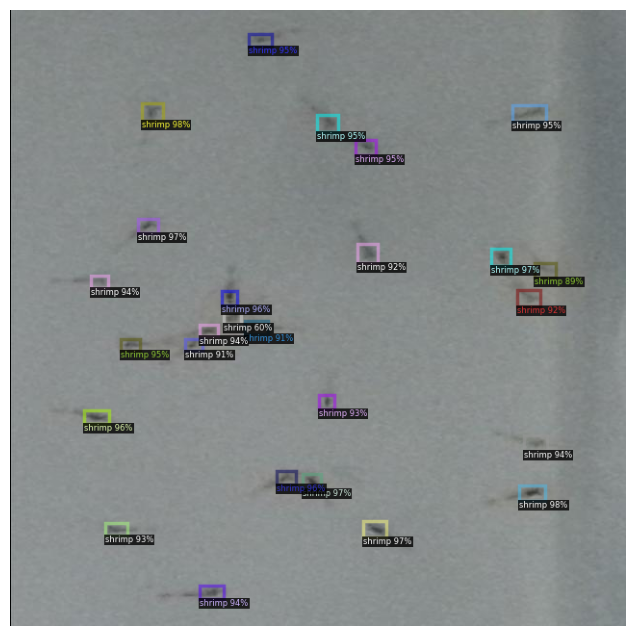

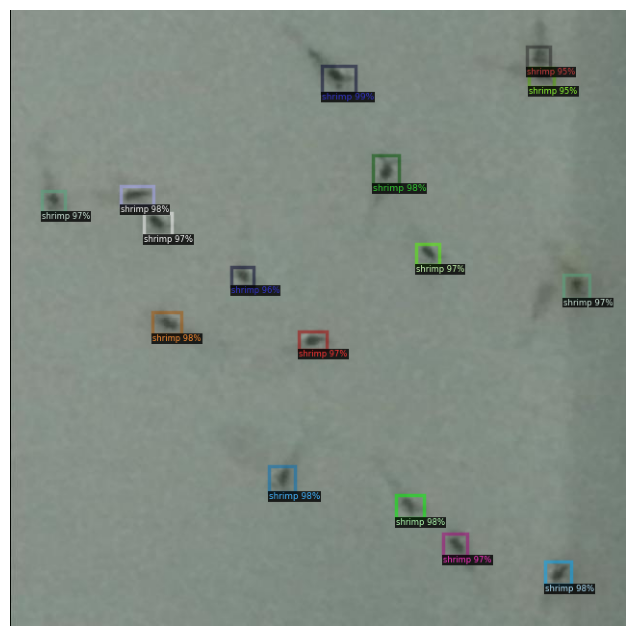

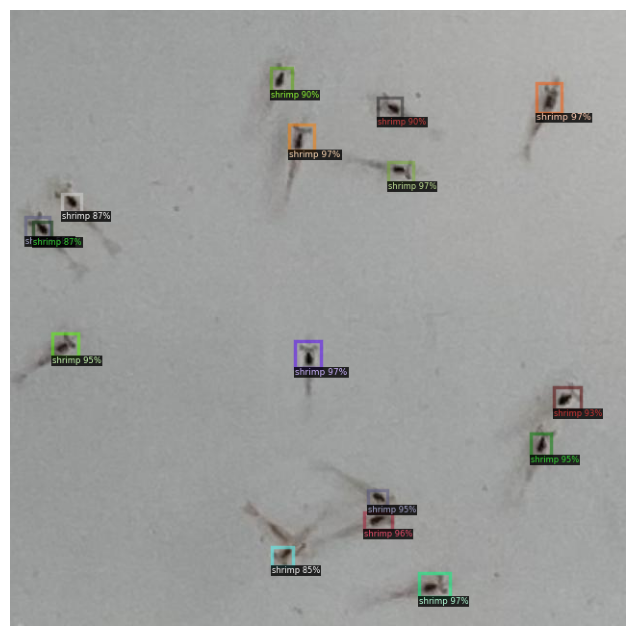

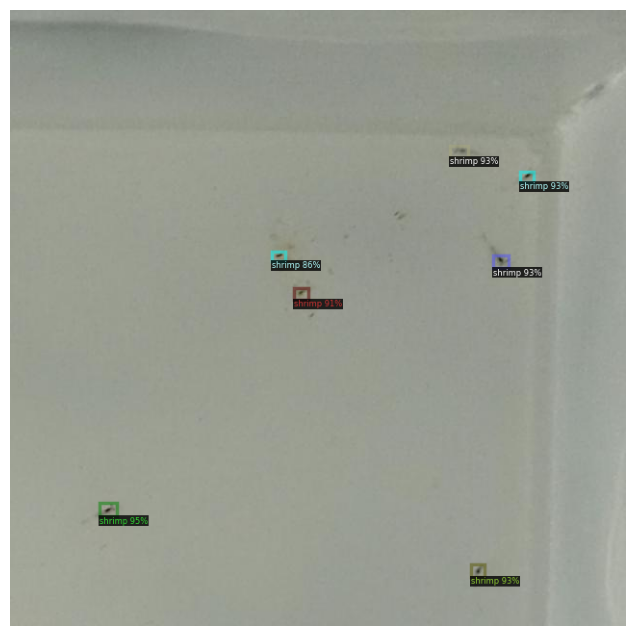

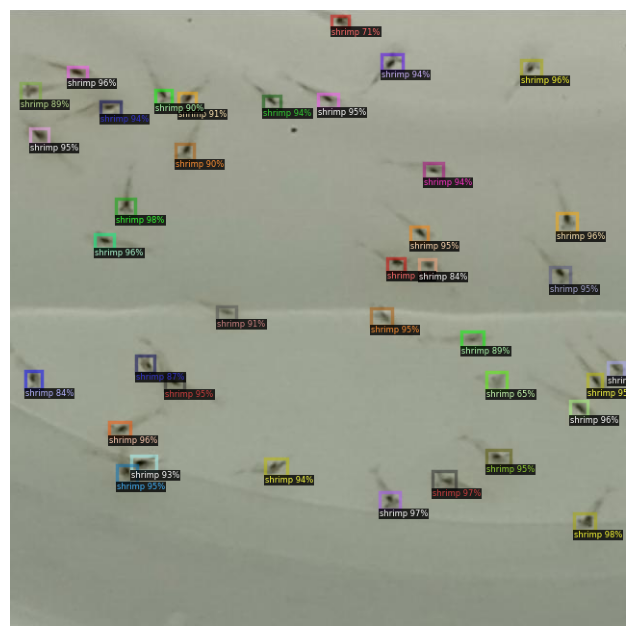

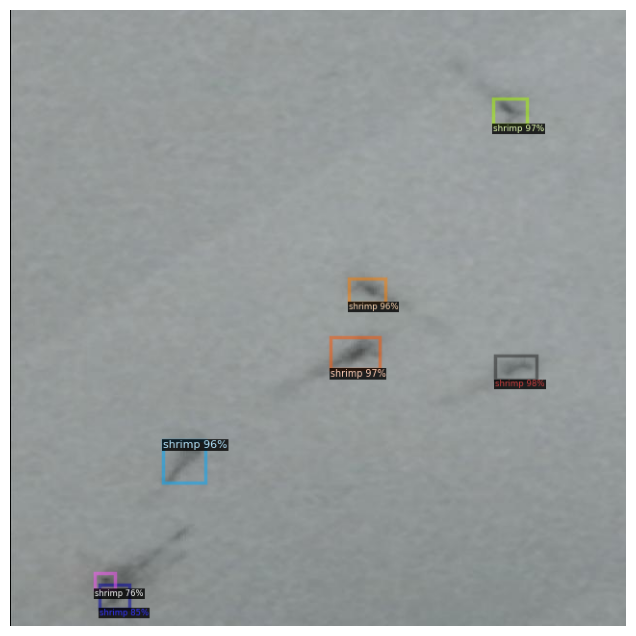

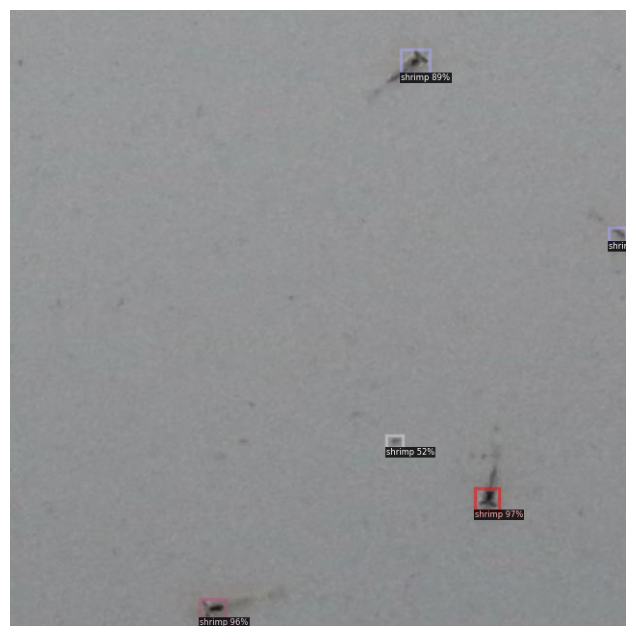

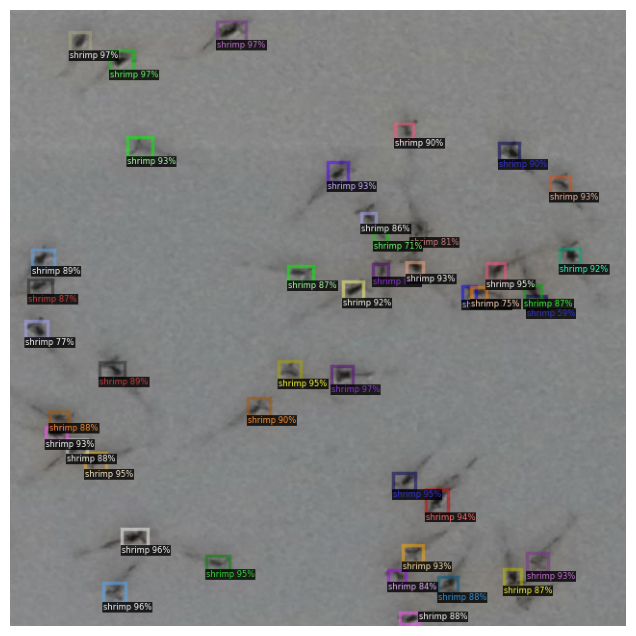

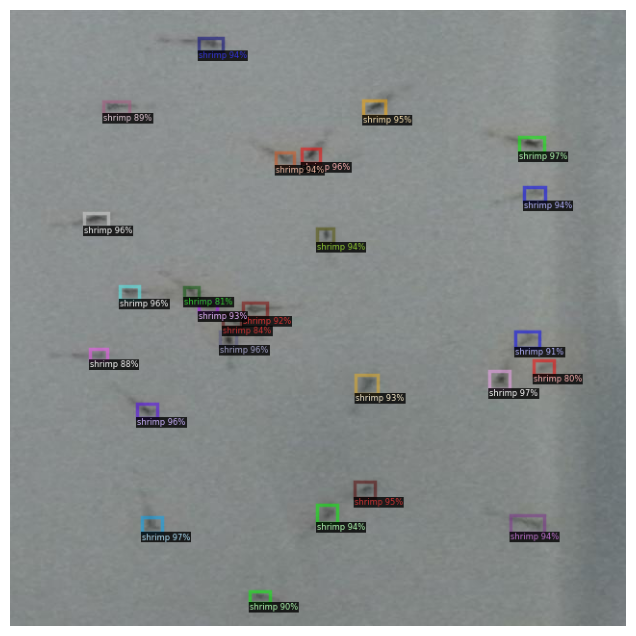

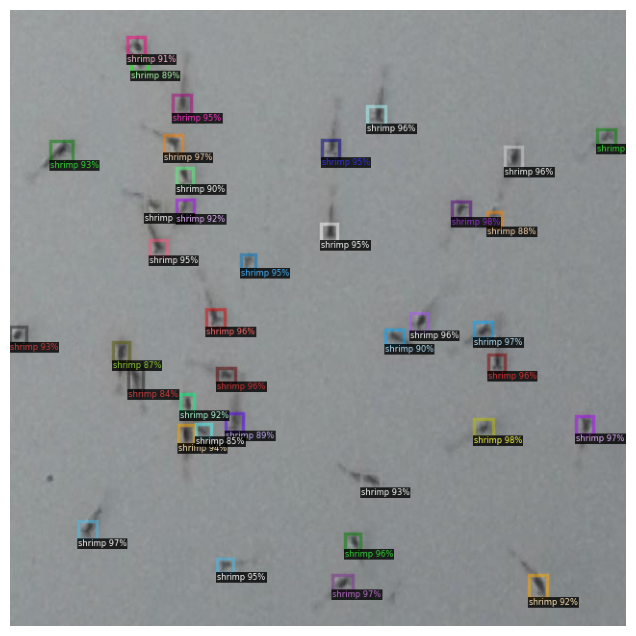

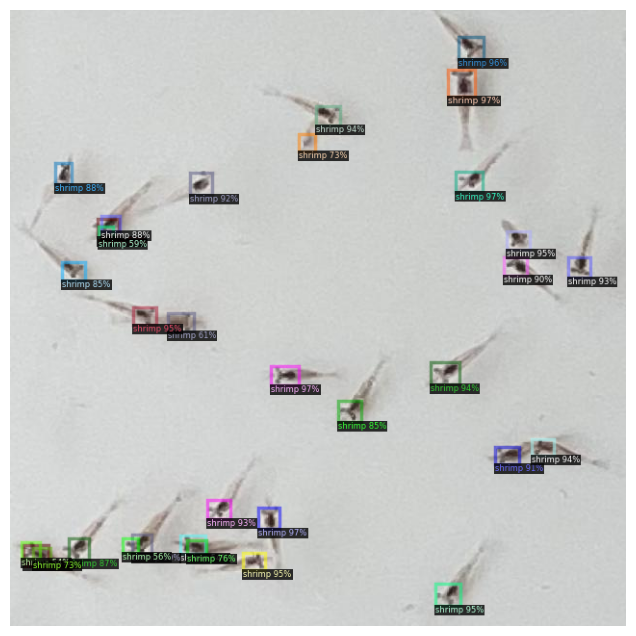

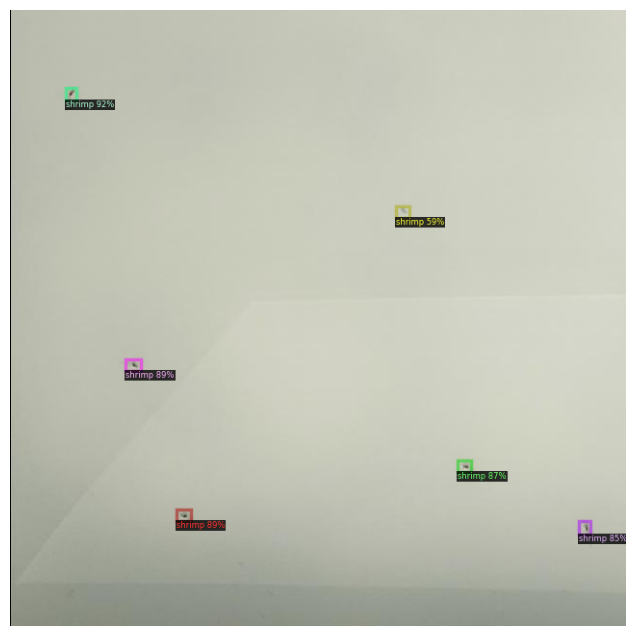

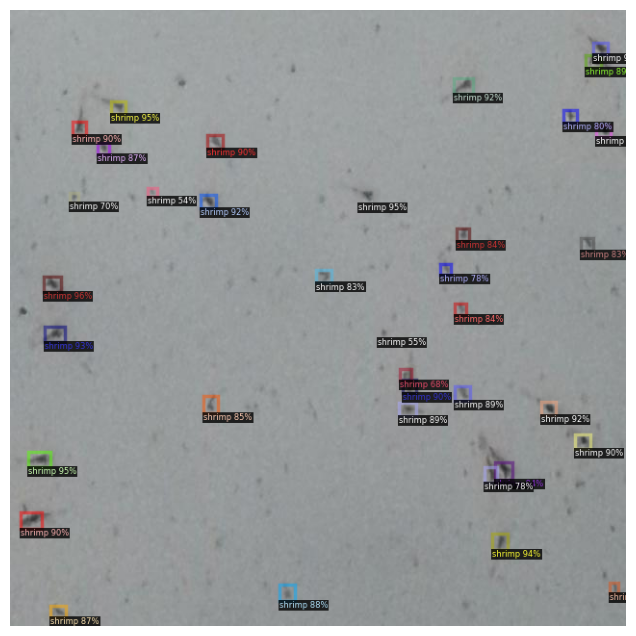

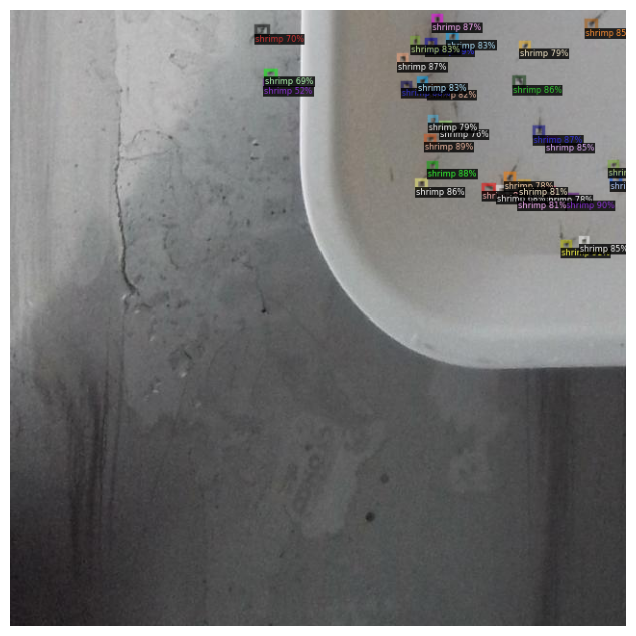

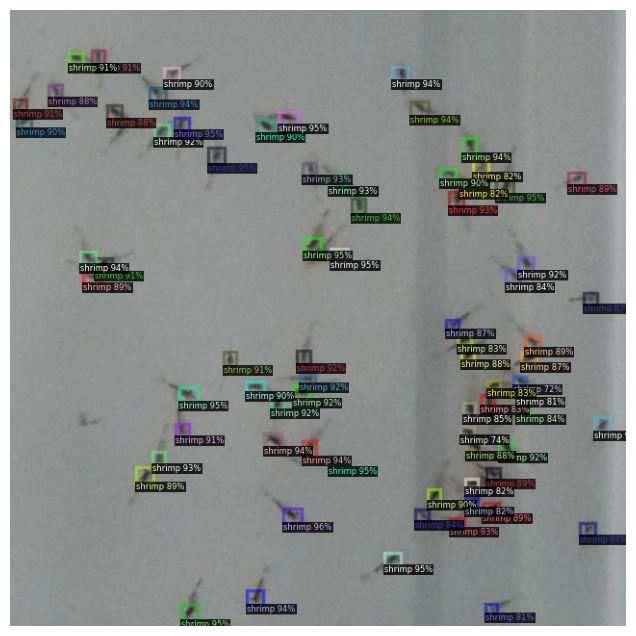

In [4]:
import matplotlib.pyplot as plt

for d in random.sample(dataset_dicts, 15):  # Change the number as needed
    img = cv2.imread(d["file_name"])
    outputs = predictor(img)

    v = Visualizer(img[:, :, ::-1], metadata=metadata, scale=1.0)
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))

    plt.figure(figsize=(8, 8))
    plt.imshow(v.get_image())
    plt.axis("off")
    plt.show()


In [5]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
evaluator = COCOEvaluator("my_dataset_test", output_dir= "./output")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
print(inference_on_dataset(predictor.model, val_loader, evaluator))

FileNotFoundError: [Errno 2] No such file or directory: 'test/_annotations.coco.json'

In [58]:
f = open('config2.yml', 'w')
f.write(cfg.dump())
f.close()

In [37]:
pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 54.3 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 76.9 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
!pip install supervision

  Using cached supervision-0.25.1-py3-none-any.whl.metadata (14 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 751.2/751.2 kB 38.9 MB/s eta 0:00:00
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 5.1
    Uninstalling PyYAML-5.1:
      Successfully uninstalled PyYAML-5.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
shrimpseedcounter 0.0.1 requires pyyaml==5.1, but you have pyyaml 6.0.2 which is incompatible.


POST PROCESSING AND MODEL LOADING

[02/13 16:43:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /teamspace/studios/this_studio/outputs/model_final.pth ...


SupervisionWarnings: `overlap_ratio_wh` in `InferenceSlicer.__init__` is deprecated and will be removed in `supervision-0.27.0`. Please manually set it to `None` and use `overlap_wh` instead.


Number of bounding boxes: 16


SupervisionWarnings: BoundingBoxAnnotator is deprecated: `BoundingBoxAnnotator` is deprecated and has been renamed to `BoxAnnotator`. `BoundingBoxAnnotator` will be removed in supervision-0.26.0.


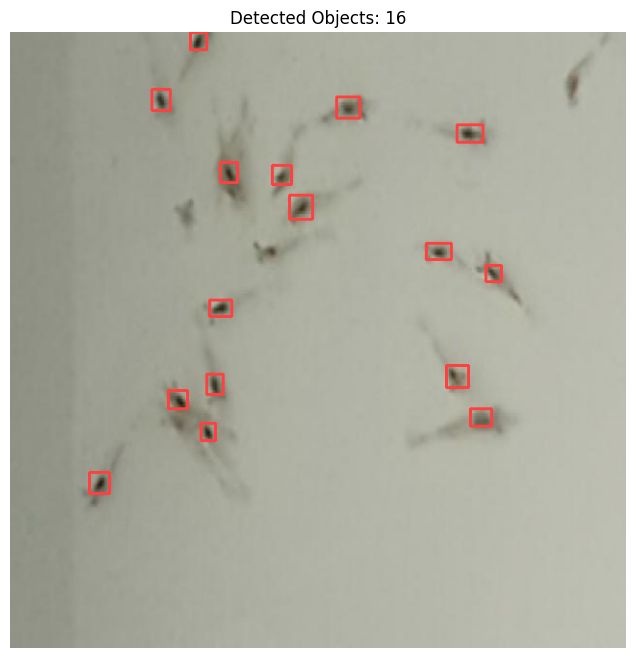

Annotated image saved to /teamspace/studios/this_studio/out.JPG


In [17]:
import supervision as sv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Load the Detectron2 model
def get_model(config_path: str, weights_path: str):
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7  # Set threshold for this model
    predictor = DefaultPredictor(cfg)
    return predictor

# Path to the config and weights files
config_path = "/teamspace/studios/this_studio/outputs/config.yml"
weights_path = "/teamspace/studios/this_studio/outputs/model_final.pth"
model = get_model(config_path, weights_path)

# Load the image
image_path = "src/artifacts/dataset/test/6451674985940_-pic_jpg.rf.d8105ce7963e408760f27a2d62add578.jpg"
image = cv2.imread(image_path)

# Callback function to perform inference on image slices
def slicer_callback(slice: np.ndarray) -> sv.Detections:
    outputs = model(slice)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else np.array([])
    scores = instances.scores.numpy() if instances.has("scores") else np.array([])
    classes = instances.pred_classes.numpy() if instances.has("pred_classes") else np.array([])

    if boxes.shape[0] == 0:  # No detections
        return sv.Detections.empty()

    # Convert the outputs to a compatible format for sv.Detections
    detection_data = {
        "xyxy": boxes,
        "confidence": scores,
        "class_id": classes
    }
    detections = sv.Detections(**detection_data)
    return detections

slicer = sv.InferenceSlicer(
    callback=slicer_callback,
    slice_wh=(512, 512),
    overlap_ratio_wh=(0.1, 0.1)
)
detections = slicer(image)

# Count the number of bounding boxes
num_detections = len(detections.xyxy)
print(f"Number of bounding boxes: {num_detections}")

# Annotate the original image with detections
annotator = sv.BoundingBoxAnnotator()
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)

# Save the annotated image
output_path = "/teamspace/studios/this_studio/out.JPG"
cv2.imwrite(output_path, annotated_frame)

# Display the annotated image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Detected Objects: {num_detections}")
plt.show()

print(f"Annotated image saved to {output_path}")


adjusting Region of intrest to avoid noise

In [ ]:
import supervision as sv
import cv2
import matplotlib.pyplot as plt
import numpy as np
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor

# Load the Detectron2 model
def get_model(config_path: str, weights_path: str):
    cfg = get_cfg()
    cfg.merge_from_file(config_path)
    cfg.MODEL.WEIGHTS = weights_path
    cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 # Set threshold for this model
    predictor = DefaultPredictor(cfg)
    return predictor

# Path to the config and weights files
config_path = "/teamspace/studios/this_studio/config.yml"
weights_path = "/teamspace/studios/this_studio/output/model_final.pth"
model = get_model(config_path, weights_path)

# Load the image
image_path = "/teamspace/studios/this_studio/IMG_7235 (1).JPG"
image = cv2.imread(image_path)
original_dims = (3000,4000)
image = cv2.resize(image, (original_dims[0], original_dims[1]))
# Define your polygonal ROI coordinates
polygon = [(340, 1020),(840,530),(2070,530),(2540, 1000), (2515, 2962), (2030, 3440), (800, 3458), (320, 2985)]

# Create ROI mask
def create_roi_mask(image_shape, polygon):
    mask = np.zeros(image_shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [np.array(polygon, dtype=np.int32)], 255)
    return mask

# Mask the ROI
mask = create_roi_mask(image.shape, polygon)
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Callback function to perform inference on image slices
def slicer_callback(slice: np.ndarray) -> sv.Detections:
    outputs = model(slice)
    instances = outputs["instances"].to("cpu")
    boxes = instances.pred_boxes.tensor.numpy() if instances.has("pred_boxes") else np.array([])
    scores = instances.scores.numpy() if instances.has("scores") else np.array([])
    classes = instances.pred_classes.numpy() if instances.has("pred_classes") else np.array([])

    if boxes.shape[0] == 0:  # No detections
        return sv.Detections.empty()

    # Convert the outputs to a compatible format for sv.Detections
    detection_data = {
        "xyxy": boxes,
        "confidence": scores,
        "class_id": classes
    }
    detections = sv.Detections(**detection_data)
    return detections

slicer = sv.InferenceSlicer(
    callback=slicer_callback,
    slice_wh=(520,520),#fix
    overlap_ratio_wh=(0.7, 0.7),
    overlap_filter_strategy=sv.OverlapFilter.NON_MAX_MERGE
)
detections = slicer(masked_image)

# Count the number of bounding boxes
num_detections = len(detections.xyxy)
print(f"Number of bounding boxes: {num_detections}")

# Annotate the original image with detections
annotator = sv.BoundingBoxAnnotator()
annotated_frame = annotator.annotate(scene=image.copy(), detections=detections)

# Save the annotated image


# Display the annotated image using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_frame, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Detected Objects: {num_detections}")
plt.show()



filtering large bounding boxes

In [ ]:
# Filtering large bounding boxes
def filter_large_bounding_boxes(detections, max_area):
    filtered_boxes = []
    filtered_scores = []
    filtered_classes = []

    for box, score, class_id in zip(detections.xyxy, detections.confidence, detections.class_id):
        x1, y1, x2, y2 = box
        area = (x2 - x1) * (y2 - y1)
        if area <= max_area:
            filtered_boxes.append(box)
            filtered_scores.append(score)
            filtered_classes.append(class_id)

    if not filtered_boxes:
        return sv.Detections.empty()

    filtered_boxes = np.array(filtered_boxes)
    filtered_scores = np.array(filtered_scores)
    filtered_classes = np.array(filtered_classes)

    detection_data = {
        "xyxy": filtered_boxes,
        "confidence": filtered_scores,
        "class_id": filtered_classes
    }
    return sv.Detections(**detection_data)

# Define the maximum allowed area for bounding boxes (example: 50000 pixels)
max_area = 900
filtered_detections = filter_large_bounding_boxes(detections, max_area)

# Count the number of bounding boxes
num_filtered_detections = len(filtered_detections.xyxy)
print(f"Number of filtered bounding boxes: {num_filtered_detections}")

# Annotate the original image with filtered detections
annotated_frame_filtered = annotator.annotate(scene=image.copy(), detections=filtered_detections)

# Save the annotated image
output_path = "/teamspace/studios/this_studio/final_imagetest3.jpg"
cv2.imwrite(output_path, annotated_frame_filtered)

# Display the annotated image with filtered detections using Matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(cv2.cvtColor(annotated_frame_filtered, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title(f"Filtered Detected Objects: {num_filtered_detections}")
plt.show()
